In [1]:
%matplotlib inline
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from forecast import SARIMAX
end = '2014'
start = '2001'

def standardization(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data-mean)/std, mean, std

def standardization_invert(data, mean, std):
    return data*std + mean

/home/xpuspus/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load Data

In [2]:
poll = pd.read_csv('data/pollution_us_2000_2016.csv')

### Pre-process Data

In [3]:
# Preprocessing take from Kaggle
## Prepare all 4 AQIs against state and date 
pollSt = poll[['State','Date Local','NO2 AQI','O3 AQI','SO2 AQI','CO AQI']]

# We delete a row with a blank value, we could populate it with the mean but since our dataset is big enough, it will not have
# a strong effect on our analysis
pollSt = pollSt.dropna(axis='rows') 

# We are only interested in the US data for this analysis
pollSt = pollSt[pollSt.State!='Country Of Mexico'] 

# Lets format the date string to an actual date value so that we can act on ranges later
pollSt['Date Local'] = pd.to_datetime(pollSt['Date Local'],format='%Y-%m-%d')

# Group by the State and Date, if there are any duplicate values (Some dates have multiple samples for AQI),
# We will take the mean of thos duplicate values
pollSt = pollSt.groupby(['Date Local']).mean()


In [4]:
# Get weakly average pollution
yn = pollSt['NO2 AQI'].resample('W').mean()

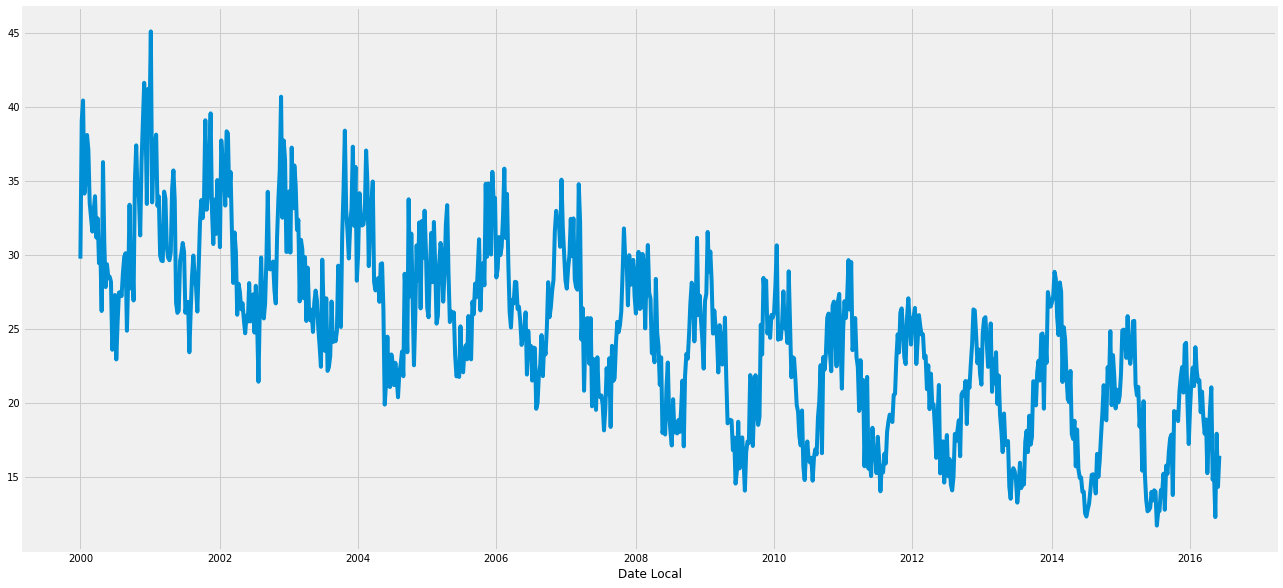

In [5]:
# Plot weakly average pollution
yn.plot(figsize = (20, 10))

# Time-Series Forecasting using SARIMAX  
### Grid Search through all combinations of the parameters

In [6]:
def gridSearch(y):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    aic = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                ydata, _, _ = standardization(y[:end])
                mod = sm.tsa.statespace.SARIMAX(ydata,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                aic.append([param, param_seasonal, results.aic])
                print('order={}, seasonality={}, - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic
aic = gridSearch(yn)

order=(0, 0, 0), seasonality=(0, 0, 1, 52), - AIC:1677.3172284635516
order=(0, 0, 0), seasonality=(0, 1, 1, 52), - AIC:1057.6441635174476
order=(0, 0, 0), seasonality=(1, 0, 0, 52), - AIC:1207.3199354626481
order=(0, 0, 0), seasonality=(1, 0, 1, 52), - AIC:1124.460982305036
order=(0, 0, 0), seasonality=(1, 1, 0, 52), - AIC:1043.8918004059174
order=(0, 0, 0), seasonality=(1, 1, 1, 52), - AIC:1045.0911705395852
order=(0, 0, 1), seasonality=(0, 0, 0, 52), - AIC:1679.8641497228607
order=(0, 0, 1), seasonality=(0, 0, 1, 52), - AIC:1332.485634096408
order=(0, 0, 1), seasonality=(0, 1, 0, 52), - AIC:1199.5106021597085
order=(0, 0, 1), seasonality=(0, 1, 1, 52), - AIC:935.3684321953056
order=(0, 0, 1), seasonality=(1, 0, 0, 52), - AIC:1105.5836418975578
order=(0, 0, 1), seasonality=(1, 0, 1, 52), - AIC:1001.394485438737
order=(0, 0, 1), seasonality=(1, 1, 0, 52), - AIC:949.5991718107915
order=(0, 0, 1), seasonality=(1, 1, 1, 52), - AIC:924.5657370890485
order=(0, 1, 0), seasonality=(0, 0, 1, 5

Pick the model with the least AIC (Akaike information criterion)

In [7]:
sorted_list = sorted(aic, key=lambda x:x[2])
sorted_list[:20]

[[(1, 1, 1), (0, 1, 1, 52), 675.6687737691632],
 [(1, 1, 1), (1, 1, 1, 52), 686.6411099396637],
 [(0, 1, 1), (0, 1, 1, 52), 702.1114207908887],
 [(1, 0, 1), (0, 1, 1, 52), 706.5042414906743],
 [(0, 1, 1), (1, 1, 1, 52), 718.1120138825854],
 [(1, 0, 1), (1, 1, 1, 52), 730.4352171116295],
 [(1, 1, 1), (1, 0, 1, 52), 782.0531190410461],
 [(0, 1, 1), (1, 0, 1, 52), 792.4657679527234],
 [(1, 0, 1), (1, 0, 1, 52), 794.2021649139921],
 [(1, 0, 1), (1, 0, 0, 52), 806.4446766681699],
 [(0, 1, 1), (0, 0, 1, 52), 806.8632299122775],
 [(1, 1, 1), (0, 0, 1, 52), 807.4116463822224],
 [(1, 0, 1), (0, 0, 1, 52), 810.2108006330159],
 [(0, 1, 1), (1, 0, 0, 52), 820.8020166510619],
 [(1, 1, 1), (1, 0, 0, 52), 821.3241489368618],
 [(1, 1, 1), (1, 1, 0, 52), 824.4043593479742],
 [(1, 1, 0), (0, 1, 1, 52), 850.6118207571349],
 [(1, 1, 0), (1, 0, 0, 52), 856.8950147758167],
 [(1, 1, 0), (1, 0, 1, 52), 857.8429099025268],
 [(1, 1, 0), (0, 0, 1, 52), 858.0182582588556]]

In [39]:
orders_best = sorted_list[0][0]
seasonal_best = sorted_list[0][1]
orders_best, seasonal_best

((1, 1, 1), (0, 1, 1, 52))

In [8]:
y = yn #re-assign variable

In [38]:
# Get best model
model = SARIMAX(y[:end], aggregation='W', order=orders_best, seasonal_order=seasonal_best, seasonality=52)
params = model.fit()

print(model.fitted.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  783
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                 822.911
Date:                            Thu, 03 May 2018   AIC                          -1637.822
Time:                                    08:50:56   BIC                          -1619.170
Sample:                                01-02-2000   HQIC                         -1630.649
                                     - 12-28-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2355      0.036      6.463      0.000       0.164       0.307
ma.L1         -0.9524      0.013   

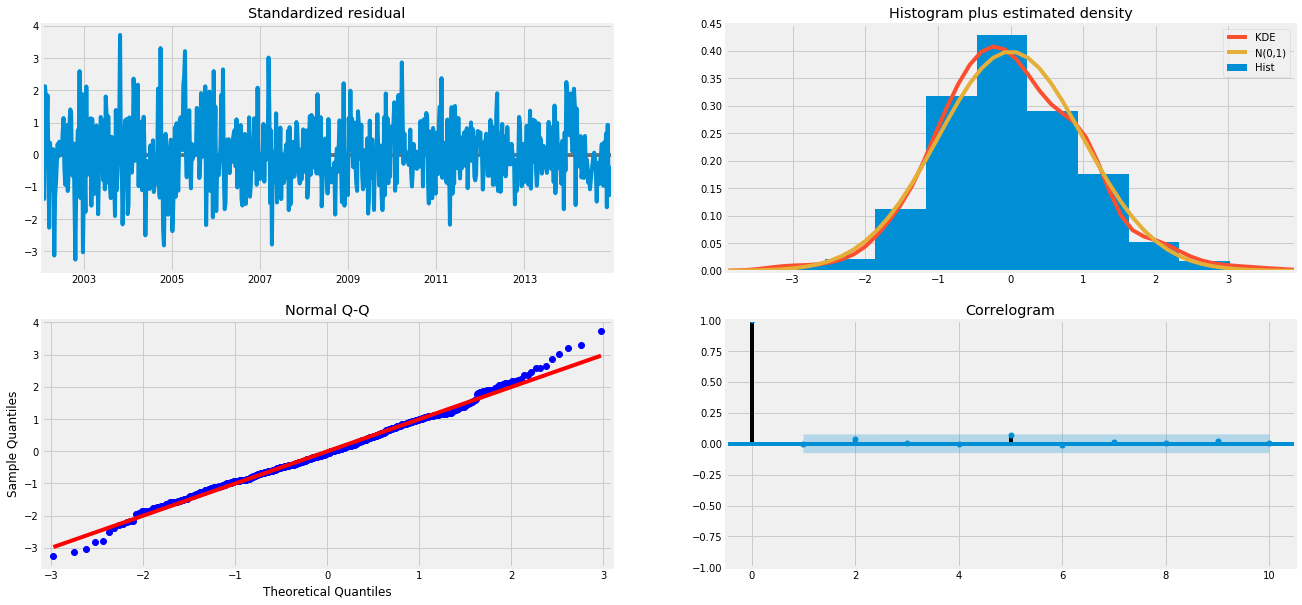

In [10]:
# Get forecast diagnostics
model.fitted.plot_diagnostics(fig=plt.figure(figsize = (20, 10)))
plt.show()

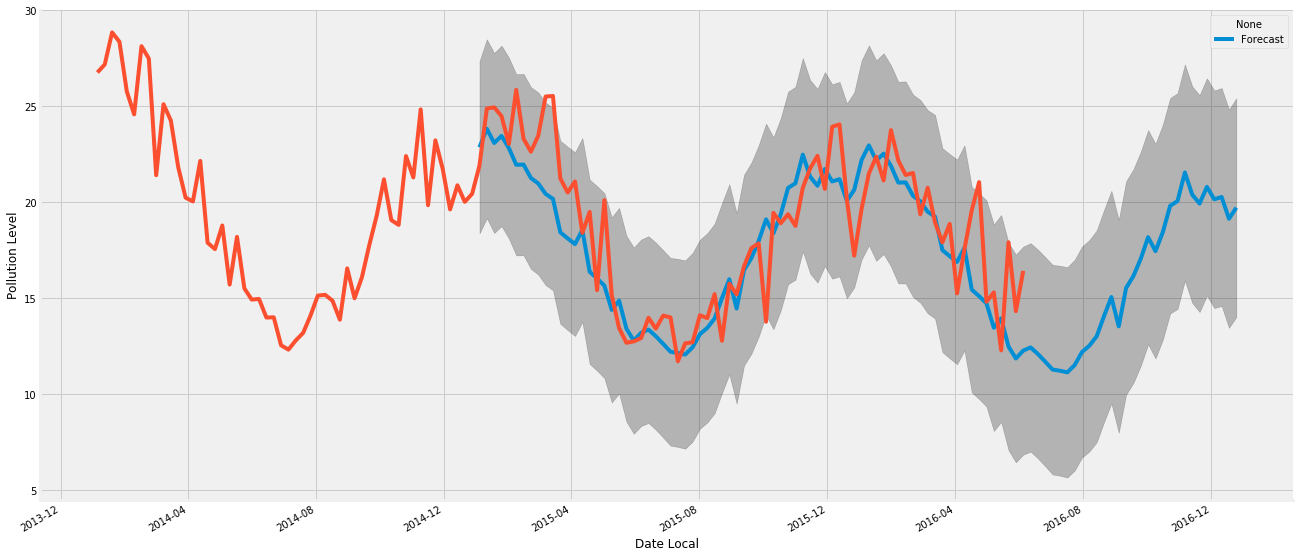

In [11]:
pred_uc = model.get_forecast(True, ci=True)

y[end:].plot(label='observed')
plt.savefig('pollution_forecast.png')
plt.show()

In [12]:
# Create dataframe of resulting prediction
pred_df = pd.DataFrame(pred_uc['pred_mean'])
pred_df['date'] = pd.DataFrame(pred_uc['dates'])
pred_df.columns = ['prediction', 'dates']

In [13]:
pred_df.head()

prediction      dates
0   22.867580 2015-01-04
1   23.835231 2015-01-11
2   23.092179 2015-01-18
3   23.463827 2015-01-25
4   22.828662 2015-02-01

In [14]:
print('The Mean Squared Error of our forecasts is {}, with mean error {}'.format(*model.benchmark()))

The Mean Squared Error of our forecasts is 0.004356955486371934, with mean error -0.0039777411950149555


# Predict Years after data

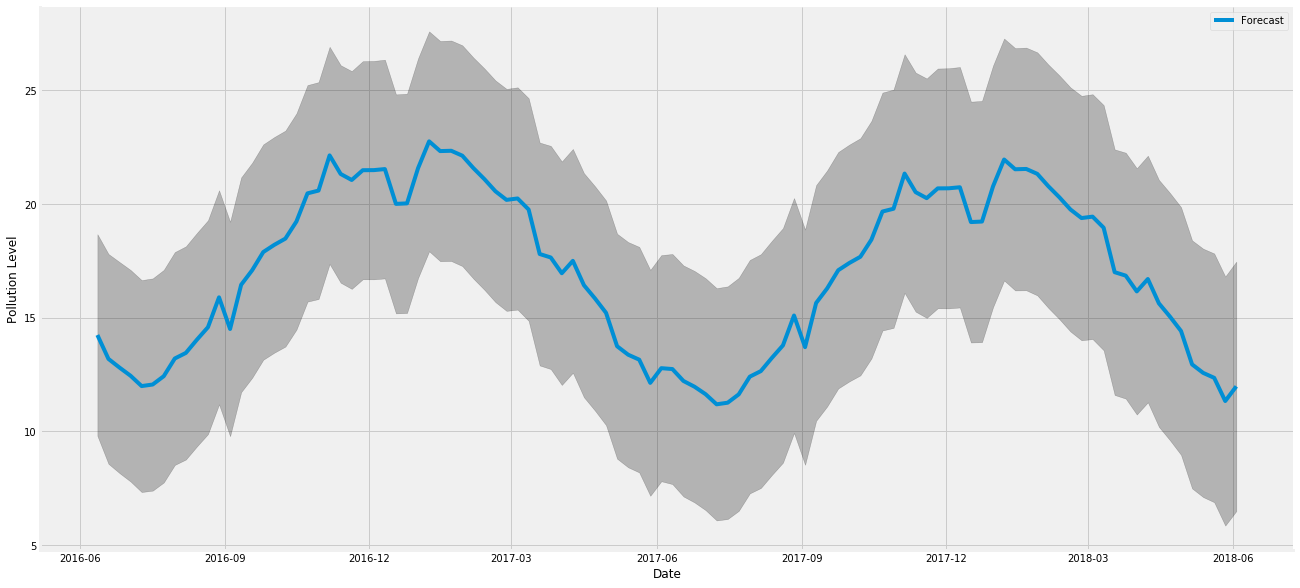

In [15]:
model_forward = SARIMAX(y, aggregation='W', order=orders_best, seasonal_order=seasonal_best, seasonality=52)
model_forward.fit()
forecast_forward = model_forward.get_forecast(True, ci=True)

In [16]:
pred_df_final = pd.DataFrame(forecast_forward['pred_mean'])
pred_df_final['date'] = pd.DataFrame(forecast_forward['dates'])
pred_df_final.columns = ['prediction', 'dates']
pred_df_final.to_csv('data/forecast.csv')

In [17]:
pred_df_final.head()

prediction      dates
0   14.240003 2016-06-12
1   13.189595 2016-06-19
2   12.808310 2016-06-26
3   12.448414 2016-07-03
4   11.994793 2016-07-10

In [18]:
pred_df_final['dates'].min(), pred_df_final['dates'].max()

(Timestamp('2016-06-12 00:00:00'), Timestamp('2018-06-03 00:00:00'))

# Segment Cities

In [19]:
# Get mean pollution (NO2 AQI) for each city and get quartiles
poll_mean_city = poll.groupby('City').agg({'NO2 AQI':'mean'})
poll_quartiles_city = poll_mean_city.describe()
poll_quartiles_city

NO2 AQI
count  144.000000
mean    23.533804
std      9.797707
min      2.049625
25%     16.973427
50%     23.739180
75%     29.186202
max     51.903226

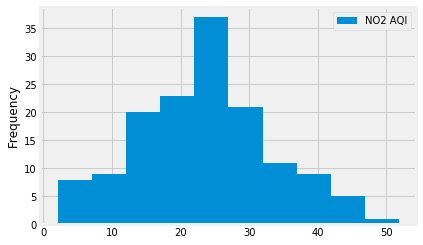

In [20]:
poll.groupby('City').agg({'NO2 AQI':'mean'}).plot(kind = 'hist')

### Clustering using K-Means

In [21]:
from sklearn.cluster import KMeans

In [22]:
kmeans = KMeans(n_clusters = 3)

In [23]:
y_label = kmeans.fit(poll_mean_city['NO2 AQI'].as_matrix().flatten().reshape(-1, 1)).predict(poll_mean_city['NO2 AQI'].as_matrix().flatten().reshape(-1, 1))

In [24]:
y_label

array([2, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 0,
       2, 0, 2, 1, 2, 2, 1, 0, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 0,
       1, 0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 0,
       0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 1, 0, 0, 2, 1, 2, 0, 1, 2, 2, 2, 0,
       0, 2, 2, 2, 1, 2, 1, 2, 1, 0, 0, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 2, 2, 1, 1,
       0, 1, 1, 2, 0, 0, 2, 2, 2, 2, 1, 2], dtype=int32)

In [25]:
poll_mean_city['K-Means Cluster'] = y_label

In [27]:
poll_mean_city.groupby('K-Means Cluster').agg({'NO2 AQI':'mean'})

NO2 AQI
K-Means Cluster           
0                38.518192
1                12.110707
2                24.720329

In [28]:
# Stats of High Pollution Cities
poll_mean_city[poll_mean_city['K-Means Cluster'] == 0]['NO2 AQI'].describe()

count    26.000000
mean     38.518192
std       4.757020
min      32.566434
25%      35.152912
50%      37.492569
75%      41.158585
max      51.903226
Name: NO2 AQI, dtype: float64

In [29]:
# Stats of Mid Pollution Cities
poll_mean_city[poll_mean_city['K-Means Cluster'] == 2]['NO2 AQI'].describe()

count    76.000000
mean     24.720329
std       3.345902
min      18.655172
25%      22.175780
50%      24.619036
75%      27.196407
max      31.403390
Name: NO2 AQI, dtype: float64

In [30]:
# Stats of Low Pollution Cities
poll_mean_city[poll_mean_city['K-Means Cluster'] == 1]['NO2 AQI'].describe()

count    42.000000
mean     12.110707
std       4.676478
min       2.049625
25%       7.835484
50%      13.013734
75%      16.278550
max      18.319646
Name: NO2 AQI, dtype: float64

In [31]:
def label_replace(x):
    if x == 0:
        return "High Pollution"
    elif x == 1:
        return 'Low Pollution'
    elif x == 2:
        return 'Mid Pollution'

In [34]:
poll_mean_city['Pollution Level'] = poll_mean_city['K-Means Cluster'].apply(lambda x: label_replace(x))
poll_mean_city.to_csv('data/pollution_level_per_city.csv')

In [35]:
poll_mean_city

NO2 AQI  K-Means Cluster  \
City                                                                        
Albuquerque                                    24.479102                2   
Alexandria                                     27.141593                2   
Altoona                                        20.687335                2   
Annandale                                      25.217219                2   
Arden-Arcade                                   20.502566                2   
Ashland                                        25.642899                2   
Athens                                          8.713656                1   
Austin                                         12.488479                1   
Bakersfield                                    51.903226                0   
Baton Rouge                                    26.817488                2   
Beaver Falls                                   26.716738                2   
Beltsville                                     17.315818                1   
Benicia                                        13.754687                1   
Berkeley                                       22.680717                2   
Bethel Island                                  13.072320                1   
Birmingham                                     21.232246                2   
Blaine                                         15.866779                1   
Boston                                         29.778324                2   
Boulder City                                   12.344884                1   
Breckenridge Hills                             28.209790                2   
Bristol                                        23.579309                2   
Burbank                                        44.419608                0   
Calexico                                       31.403390                2   
Calumet City (PU RR name Calumet Park (sta.))  38.244514                0   
Camden                                         29.696709                2   
Capitan                                         4.848215                1   
Charleroi                                      19.782843                2   
Charlotte                                      23.145133                2   
Cherry Tree                                     5.445511                1   
Chicago                                        46.869258                0   
...                                                  ...              ...   
San Diego                                      35.771688                0   
San Francisco                                  27.171144                2   
San Jose                                       23.388271                2   
San Pablo                                      20.976321                2   
Scottsdale                                     41.991469                0   
Scranton                                       24.735978                2   
Seattle                                        21.694387                2   
Seven Corners                                  33.135546                0   
Sioux Falls                                    12.177083                1   
St. Ann                                        33.725581                0   
St. Louis                                      29.414800                2   
Sunset Hills                                   26.814600                2   
Tijuana                                        38.522780                0   
Tucson                                         27.822740                2   
Tulsa                                          18.736153                2   
Vallejo                                        19.313540                2   
Valrico                                        11.688958                1   
Vandenberg Air Force Base                       2.049625                1   
Victorville                                    34.866790                0   
Vinton                                       